In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns

from pydantic import BaseModel, Field, model_validator, field_validator
from numpy.typing import NDArray

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "multilevel_elasticities"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
class Sku(BaseModel):
    id: int = Field(..., ge=0)
    prices: NDArray[np.float_]
    sales: NDArray[np.float_]

    class Config:
        arbitrary_types_allowed = True

    @field_validator("prices", "sales")
    def validate_gt_0(cls, value):
        if (value <= 0).any():
            raise ValueError("prices and sales must be positive")
        return value

    @field_validator("prices", "sales")
    def validate_size_gt_0(cls, value):
        if value.size == 0:
            raise ValueError("prices and sales must have at least one element")
        return value

    @model_validator(mode="before")
    def validate_sizes(cls, values):
        if values["prices"].size != values["sales"].size:
            raise ValueError("prices and sales must have the same size")
        return values

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            data={
                "item_id": self.id,
                "price": self.prices,
                "sales": self.sales,
                "time_step": np.arange(self.prices.size)[::-1],
            }
        )


class Store(BaseModel):
    id: int = Field(..., ge=0)
    items: list[Sku] = Field(..., min_items=1)

    @field_validator("items")
    def validate_item_ids(cls, value):
        if len({item.id for item in value}) != len(value):
            raise ValueError("items must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([item.to_dataframe() for item in self.items], axis=0)
        df["store_id"] = self.id
        df["region_store_id"] = f"r-{self.id}_s-" + df["store_id"].astype(str)
        return df.reset_index(drop=True)


class Region(BaseModel):
    id: int = Field(..., ge=0)
    stores: list[Store] = Field(..., min_items=1)
    median_income: float = Field(..., gt=0)  # Z_j

    @field_validator("stores")
    def validate_store_ids(cls, value):
        if len({store.id for store in value}) != len(value):
            raise ValueError("stores must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([store.to_dataframe() for store in self.stores], axis=0)
        df["region_id"] = self.id
        df["median_income"] = self.median_income
        return df.reset_index(drop=True)


class Market(BaseModel):
    regions: list[Region] = Field(..., min_items=1)

    @field_validator("regions")
    def validate_region_ids(cls, value):
        if len({region.id for region in value}) != len(value):
            raise ValueError("regions must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([region.to_dataframe() for region in self.regions], axis=0)
        return df.reset_index(drop=True)


In [4]:
class LinearRegressionConfig(BaseModel):
    intercept: float
    slope: float
    sigma: float = Field(..., gt=0)


class MultiLevelElasticitiesDataGenerator(BaseModel):
    rng: np.random.Generator
    n_regions: int = Field(..., gt=0)
    time_range_mu: float = Field(..., gt=0)
    time_range_sigma: float = Field(..., gt=0)
    n_stores_per_region_mu: float = Field(..., gt=0)
    n_stores_per_region_sigma: float = Field(..., gt=0)
    median_income_per_region_mu: float = Field(..., gt=0)
    median_income_per_region_sigma: float = Field(..., gt=0)
    intercepts_lr_config: LinearRegressionConfig
    slopes_lr_config: LinearRegressionConfig
    price_mu: float = Field(..., gt=0)
    price_sigma: float = Field(..., gt=0)
    epsilon: float = Field(..., gt=0)

    class Config:
        arbitrary_types_allowed = True

    def get_n_stores_per_region_draws(self) -> NDArray:
        n_stores_per_region_dist = pm.NegativeBinomial.dist(
            mu=self.n_stores_per_region_mu, alpha=self.n_stores_per_region_sigma
        )
        n_stores_per_region_draws = pm.draw(
            n_stores_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return n_stores_per_region_draws + 2

    def get_median_income_per_region_draws(self) -> NDArray:
        median_income_per_region_dist = pm.Gamma.dist(
            mu=self.median_income_per_region_mu,
            sigma=self.median_income_per_region_sigma,
        )
        median_income_per_region_draws = pm.draw(
            median_income_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return median_income_per_region_draws + 1

    def get_store_time_range(self) -> int:
        time_range_dist = pm.NegativeBinomial.dist(
            mu=self.time_range_mu, alpha=self.time_range_sigma
        )
        time_range_samples = pm.draw(
            vars=time_range_dist, draws=1, random_seed=self.rng
        ).item()
        return time_range_samples + 2

    def get_alpha_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        alpha_j_dist = pm.Normal.dist(
            mu=self.intercepts_lr_config.intercept
            + self.intercepts_lr_config.slope * median_income_per_region,
            sigma=self.intercepts_lr_config.sigma,
        )
        return pm.draw(alpha_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_beta_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        beta_j_dist = pm.Normal.dist(
            mu=self.slopes_lr_config.intercept
            + self.slopes_lr_config.slope * median_income_per_region,
            sigma=self.slopes_lr_config.sigma,
        )
        return pm.draw(beta_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_prices_samples(self, store_time_range: int) -> NDArray:
        price_dist = pm.Gamma.dist(
            mu=self.price_mu,
            sigma=self.price_sigma,
        )
        return pm.draw(price_dist, draws=store_time_range, random_seed=self.rng)

    def get_sales_samples(
        self, alpha_j_samples, beta_j_samples, prices_samples
    ) -> NDArray:
        log_sales_dist = pm.Normal.dist(
            mu=alpha_j_samples + beta_j_samples * np.log(prices_samples),
            sigma=self.epsilon,
        )
        log_sales_samples = pm.draw(log_sales_dist, draws=1, random_seed=self.rng)
        return np.exp(log_sales_samples)

    def create_store(self, id: int, median_income_per_region: float) -> Store:
        store_time_range = self.get_store_time_range()
        alpha_j_samples = self.get_alpha_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        beta_j_samples = self.get_beta_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        prices_samples = self.get_prices_samples(store_time_range=store_time_range)
        sales_samples = self.get_sales_samples(
            alpha_j_samples=alpha_j_samples,
            beta_j_samples=beta_j_samples,
            prices_samples=prices_samples,
        )
        return Store(
            id=id, items=[Sku(id=0, prices=prices_samples, sales=sales_samples)]
        )

    def create_region(
        self, id: int, n_stores_per_region: int, median_income_per_region: float
    ) -> Region:
        stores: list[Store] = [
            self.create_store(id=i, median_income_per_region=median_income_per_region)
            for i in range(n_stores_per_region)
        ]
        return Region(id=id, stores=stores, median_income=median_income_per_region)

    def run(self) -> Market:
        n_stores_per_region_draws = self.get_n_stores_per_region_draws()
        median_income_per_region_draws = self.get_median_income_per_region_draws()

        regions: list[Region] = [
            self.create_region(
                id=j,
                n_stores_per_region=n_stores_per_region_draws[j],
                median_income_per_region=median_income_per_region_draws[j],
            )
            for j in range(self.n_regions)
        ]

        return Market(regions=regions)


In [5]:
data_generator = MultiLevelElasticitiesDataGenerator(
    rng=rng,
    n_regions=5,
    time_range_mu=20,
    time_range_sigma=5,
    n_stores_per_region_mu=20,
    n_stores_per_region_sigma=2,
    median_income_per_region_mu=10,
    median_income_per_region_sigma=1,
    intercepts_lr_config=LinearRegressionConfig(intercept=0.5, slope=0.1, sigma=0.02),
    slopes_lr_config=LinearRegressionConfig(intercept=0.1, slope=0.8, sigma=0.03),
    price_mu=1.5,
    price_sigma=0.25,
    epsilon=0.1,
)

In [6]:
market = data_generator.run()

In [7]:
market_df = market.to_dataframe()

market_df.head()

,item_id,price,sales,time_step,store_id,region_store_id,region_id,median_income
0,0,2.031289,877.215320,49,0,r-0_s-0,0,9.296933
1,0,1.326435,34.205446,48,0,r-0_s-0,0,9.296933
2,0,1.685275,227.868084,47,0,r-0_s-0,0,9.296933
3,0,1.542443,115.129248,46,0,r-0_s-0,0,9.296933
4,0,1.890719,520.188187,45,0,r-0_s-0,0,9.296933


Text(0.5, 1.0, 'Price by Store in Region 4')

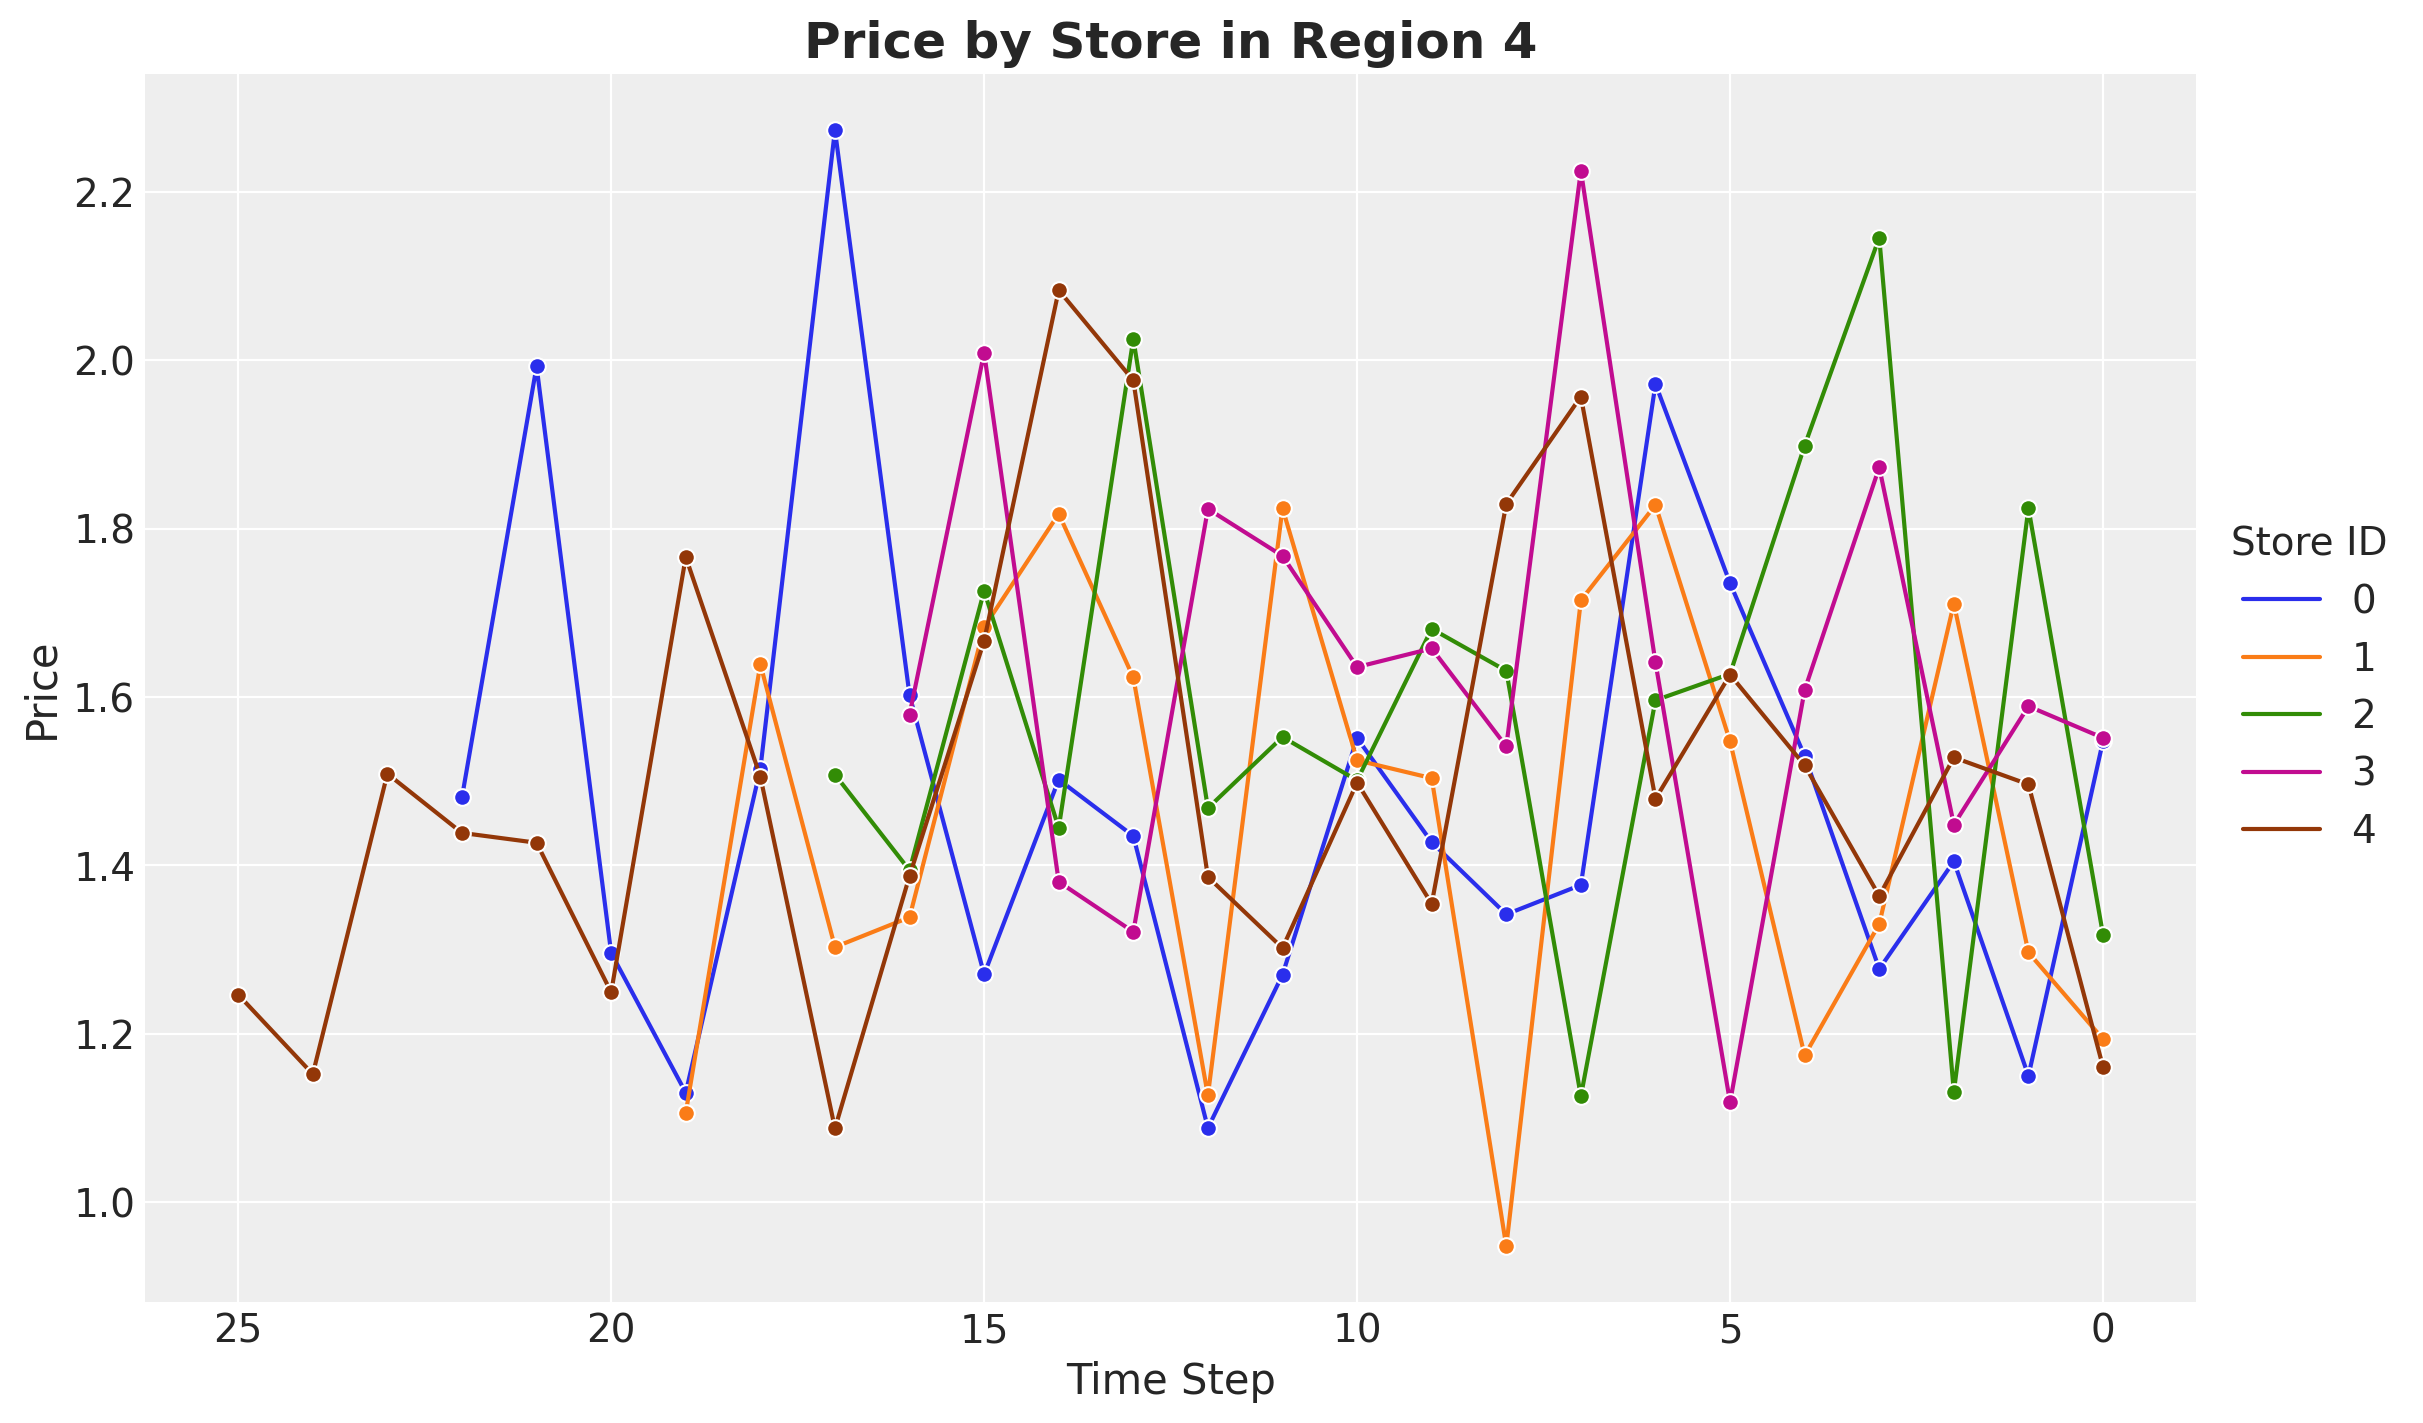

In [8]:
fig, ax = plt.subplots()
sns.lineplot(
    data=market_df.query("region_id == 4").assign(
        store_id=lambda x: x["store_id"].astype("category")
    ),
    x="time_step",
    y="price",
    hue="store_id",
    marker="o",
)
ax.invert_xaxis()
ax.legend(
    title="Store ID", title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5)
)
ax.set(xlabel="Time Step", ylabel="Price")
ax.set_title(label="Price by Store in Region 4", fontsize=18, fontweight="bold")

In [9]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = np.log(price)
sales = market_df["sales"].to_numpy()
log_sales = np.log(sales)
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
store_idx, store = market_df["region_store_id"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)

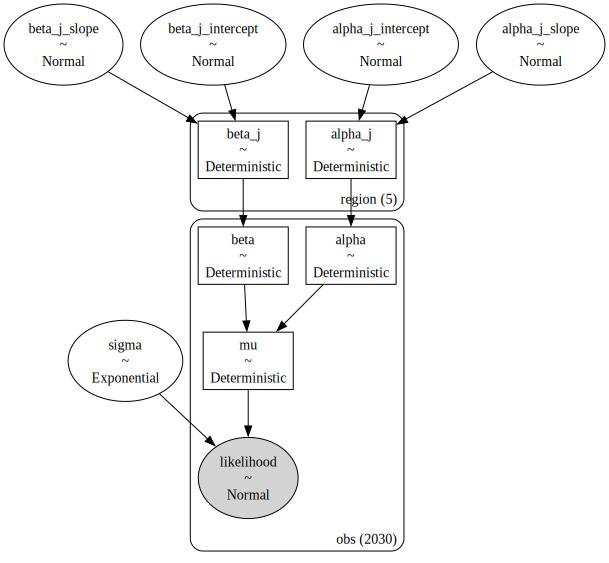

In [19]:
coords = {"store": store, "region": region, "obs": obs}

with pm.Model(coords=coords) as model:
    # --- Priors ---

    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=2)
    alpha_j_slope = pm.Normal(name="alpha_j_slope", mu=0, sigma=2)

    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=2)
    beta_j_slope = pm.Normal(name="beta_j_slope", mu=0, sigma=2)

    sigma = pm.Exponential(name="sigma", lam=1)

    # --- Parametrization ---

    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
        dims="region",
    )

    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

    pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=log_sales, dims="obs")

    # --- Likelihood ---

pm.model_to_graphviz(model=model)


In [20]:
with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=2_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.410317
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.145669
Transforming variables...


Sampling: [likelihood]


Transformation time =  0:00:00.295274


In [21]:
idata["sample_stats"]["diverging"].sum().item()

0

In [22]:
var_names = [
    "alpha_j_intercept",
    "alpha_j_slope",
    "beta_j_intercept",
    "beta_j_slope",
    "alpha_j",
    "beta_j",
    "sigma",
]

az.summary(data=idata, var_names=var_names)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_j_intercept,1.238,0.241,0.783,1.691,0.006,0.005,1480.0,2067.0,1.0
alpha_j_slope,0.027,0.023,-0.016,0.070,0.001,0.000,1489.0,1964.0,1.0
beta_j_intercept,4.370,0.562,3.283,5.400,0.015,0.010,1451.0,2034.0,1.0
beta_j_slope,0.385,0.053,0.290,0.490,0.001,0.001,1456.0,2017.0,1.0
alpha_j[0],1.490,0.036,1.423,1.557,0.001,0.001,2016.0,2733.0,1.0
alpha_j[1],1.513,0.025,1.466,1.558,0.000,0.000,4688.0,4594.0,1.0
alpha_j[2],1.534,0.024,1.488,1.580,0.000,0.000,5805.0,4871.0,1.0
alpha_j[3],1.547,0.030,1.492,1.603,0.001,0.000,3128.0,4305.0,1.0
alpha_j[4],1.572,0.047,1.488,1.659,0.001,0.001,1989.0,2802.0,1.0
beta_j[0],7.952,0.085,7.795,8.112,0.002,0.001,2025.0,2873.0,1.0


[Text(0.5, 1.0, 'Posterior Predictive Check'), Text(0.5, 0, 'likelihood')]

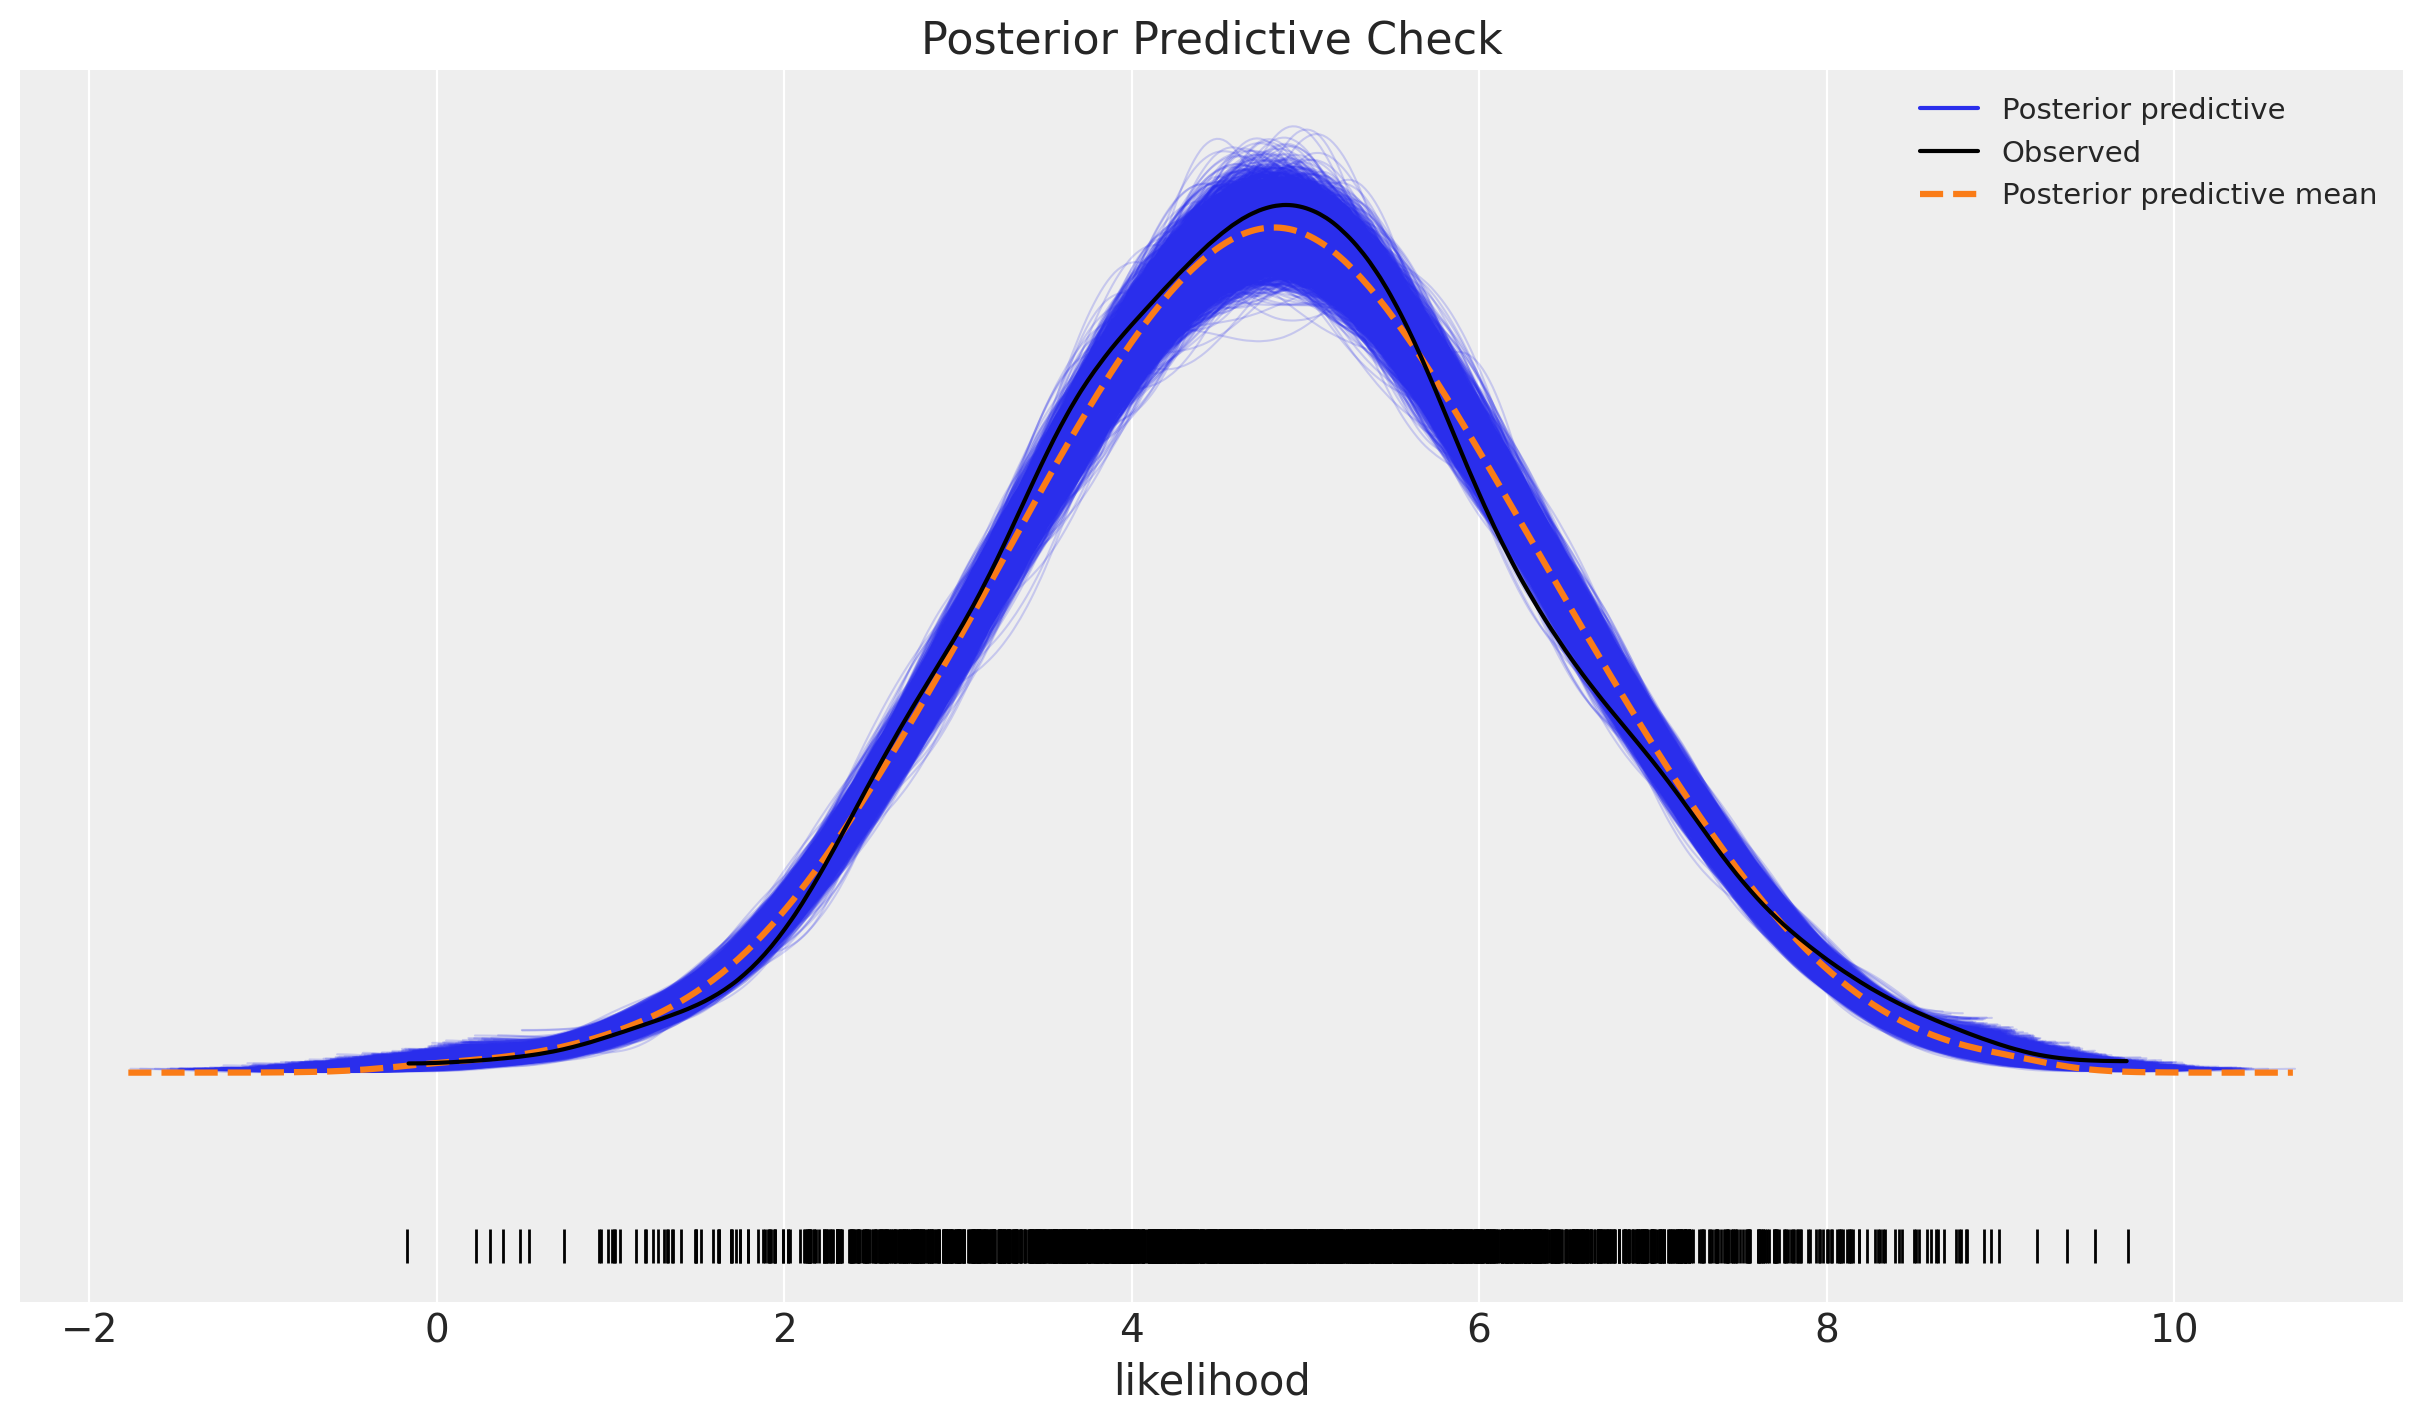

In [23]:
ax = az.plot_ppc(
    data=posterior_predictive,
    observed_rug=True,
    random_seed=seed,
)
ax.set(
    title="Posterior Predictive Check",
    xlabel="likelihood",
    # xlim=(-0.5, 1.5),
)


In [31]:
posterior_predictive["posterior_predictive"]["likelihood"].mean(dim=("chain", "draw"))


<xarray.DataArray 'likelihood' (obs: 2030)>
array([7.1206966 , 3.73448565, 5.63902706, ..., 5.43217284, 5.23717221,
       2.92897939])
Coordinates:
  * obs      (obs) int64 0 1 2 3 4 5 6 7 ... 2023 2024 2025 2026 2027 2028 2029